<a href="https://colab.research.google.com/github/Mahiyan-Khan-Abir/Projects_2022-2023/blob/main/Breast_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Sep 17 13:00:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#importing dependancies
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions


**Data Loader**

In [ ]:
# The code is defining a frame object called `frameObjTrain` which has two empty lists, `img` and `mask`,
# to store image and mask data respectively.
## defining a frame for image and mask storage
framObjTrain = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    """
     Loads data from images and masks. This function is used to load image and mask data from images and masks.

     @param frameObj - Dictionary to store data in. If None is passed a new dictionary will be created
     @param imgPath - Path to the images.
     @param maskPath - Path to the masks. It is assumed that the images are in png format
     @param shape - Shape of the image.

     @return Dictionary with loaded data. If None is passed a new dictionary will be created
    """
    imgNames = os.listdir(imgPath)

    names = []
    maskNames = []
    unames = [imgNames[i].split(')')[0] for i in range(len(imgNames))]
    unames = list(set(unames))  #List=array

    # Add the names and mask names to the names and mask names.
    for uname in unames:
        names.append(f'{uname}).png')
        maskNames.append(f'{uname})_mask.png')

    imgAddr = f'{imgPath}/'   #path = location
    maskAddr = f'{maskPath}/'

    # Draw all images and masks in the frameObj.
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])

        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        frameObj['img'].append(img)
        frameObj['mask'].append(mask)

    return frameObj

In [ ]:
# The code is loading benign and malignant samples of breast ultrasound images and storing them in the
# `framObjTrain` object. The `LoadData` function is used to load the
# images and masks from the specified paths (`imgPath` and `maskPath`) and resize them to a shape of 256x256 pixels.
# The loaded samples are then added to the `framObjTrain` object.

framObjTrain = LoadData( framObjTrain, imgPath = '/content/drive/MyDrive/cancer/ultrasound/Dataset_BUSI_with_GT/benign'
                        , maskPath = '/content/drive/MyDrive/cancer/ultrasound/Dataset_BUSI_with_GT/benign'
                        , shape = 256)
# loading malignant samples

framObjTrain = LoadData( framObjTrain, imgPath = '/content/drive/MyDrive/cancer/ultrasound/Dataset_BUSI_with_GT/malignant'
                        , maskPath = '/content/drive/MyDrive/cancer/ultrasound/Dataset_BUSI_with_GT/malignant'
                        , shape = 256)

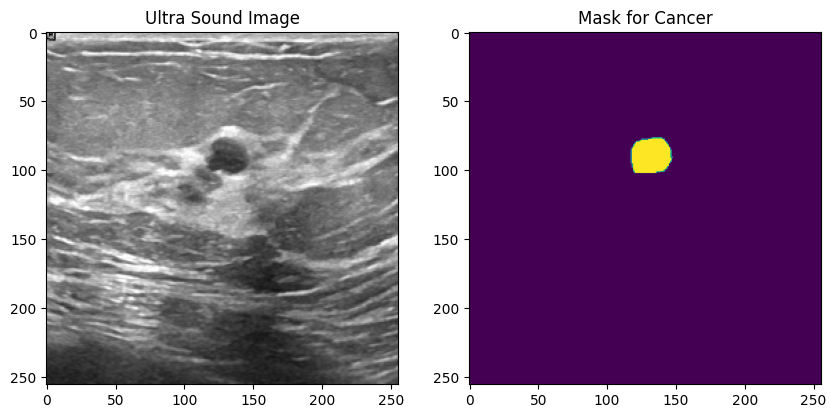

In [ ]:
## displaying data loaded by our function
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.title('Mask for Cancer')
plt.show()

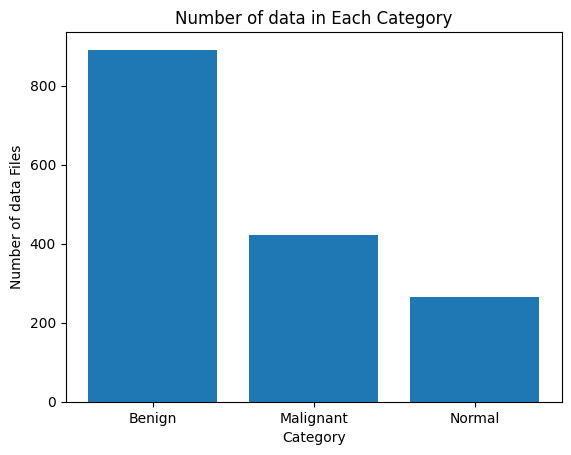

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the paths to the directories containing PNG files and mask files
benign_img_dir = '/content/drive/MyDrive/cancer/ultrasound/Dataset_BUSI_with_GT/benign'
malignant_img_dir = '/content/drive/MyDrive/cancer/ultrasound/Dataset_BUSI_with_GT/malignant'
normal_img_dir= '/content/drive/MyDrive/cancer/ultrasound/Dataset_BUSI_with_GT/normal'
# Count the number of PNG files in each directory
benign_png_count = len([file for file in os.listdir(benign_img_dir) if file.lower().endswith('.png')])
malignant_png_count = len([file for file in os.listdir(malignant_img_dir) if file.lower().endswith('.png')])
normal_img_count = len([file for file in os.listdir(normal_img_dir) if file.lower().endswith('.png')])
# Create a bar chart to visualize the counts
categories = ['Benign', 'Malignant', 'Normal']
counts = [benign_png_count, malignant_png_count, normal_img_count]

plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of data Files')
plt.title('Number of data in Each Category')
plt.show()


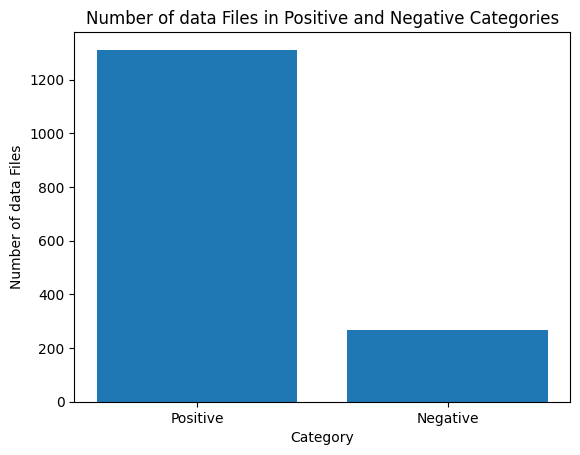

In [ ]:
positive_png_count = benign_png_count + malignant_png_count

# Create a bar chart to visualize the counts
categories = ['Positive', 'Negative']
counts = [positive_png_count, normal_img_count]

plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of data Files')
plt.title('Number of data Files in Positive and Negative Categories')
plt.show()

After feature scalling, The dataset would be noramalized

In [ ]:
# The `Conv2dBlock` function creates a convolutional block consisting of two convolutional
# layers with batch normalization and ReLU activation. It takes an input tensor,
# the number of filters in the convolutional block, the kernel size, and a flag indicating
# whether to perform batch normalization. It returns the output tensor after passing through the convolutional block.
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    """
     Creates a conv block. It is assumed that the input tensor has been preprocessed by the block before.

     @param inputTensor - The input tensor to the block. Must be preprocessed by the block
     @param numFilters - The number of filters in the convolution block
     @param kernelSize - The
     @param doBatchNorm
    """
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    # Batch normalization. If doBatchNorm is true batch normalization is performed.
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    # Batch normalization. If doBatchNorm is true batch normalization is performed.
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x


# Now defining Unet
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    """
     Give me unet convolutions. It takes a batch of images and groups them into numFilters * 2 convolutions

     @param inputImage - The input image to be convoluted
     @param numFilters - The number of filters in the convolutional layers
     @param droupouts - The number of groupouts to be applied
     @param doBatchNorm - Whether to batch - normalize the input

     @return A tuple of ( Conv2dBlock Path )
    """
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)

    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    return tf.keras.Model(inputs = [inputImage], outputs = [output])

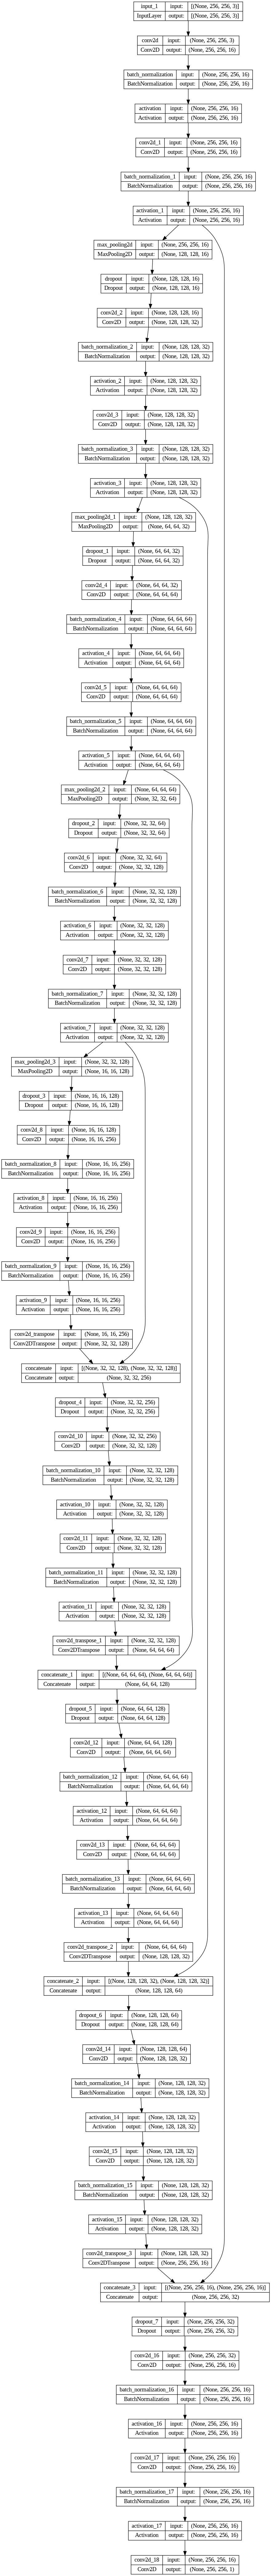

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Define the input shape of your images
height = 256
width = 256
channels = 3

# Create an instance of the UNet model
inputImage = tf.keras.layers.Input(shape=(height, width, channels))
model = GiveMeUnet(inputImage)  # Replace with your model creation code

# Plot the model architecture and save it as a PNG image
plot_model(model, to_file='model_plot_GiveUnet.png', show_shapes=True, show_layer_names=True)


**Model Instantiation**

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

**Trainings**

In [ ]:
EPOCHS = 50

In [ ]:
from tqdm import tqdm
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.epochs, desc="Training")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

# Create an instance of the TQDMProgressBar callback
pbar_callback = TQDMProgressBar()

# Train your model
retVal = myTransformer.fit(
    np.array(framObjTrain['img']), np.array(framObjTrain['mask']),
    epochs=EPOCHS, batch_size=8,
    workers=4, use_multiprocessing=True,
    callbacks=[pbar_callback],
    verbose=0
)

Training: 100%|██████████| 50/50 [08:49<00:00, 10.58s/it]


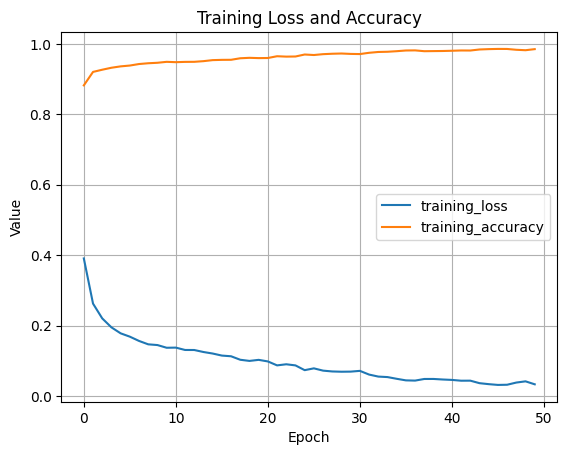

In [ ]:
# Plot training loss
plt.plot(retVal.history['loss'], label='training_loss')

# Check if 'accuracy' is present in the history dictionary before plotting
if 'accuracy' in retVal.history:
    plt.plot(retVal.history['accuracy'], label='training_accuracy')

# Set labels and legend
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
if 'accuracy' in retVal.history:
    accuracies = retVal.history['accuracy']
    average_accuracy = sum(accuracies) / len(accuracies)
    print("Average Accuracy:", average_accuracy)

Average Accuracy: 0.963343014717102


**Testing**

In [ ]:
def predicts(valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][:15]
    mask = valMap['mask'][:15]

    imgProc = img[:15]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    _extracted_from_Plotter_4(1, img, ' image')
    _extracted_from_Plotter_4(2, predMask, 'Predicted mask')
    _extracted_from_Plotter_4(3, groundTruth, 'Actual mask')


# TODO Rename this here and in `Plotter`
def _extracted_from_Plotter_4(arg0, arg1, arg2):
    plt.subplot(1, 3, arg0)
    plt.imshow(arg1)
    plt.title(arg2)


1/1 [==============================] - 0s 32ms/step


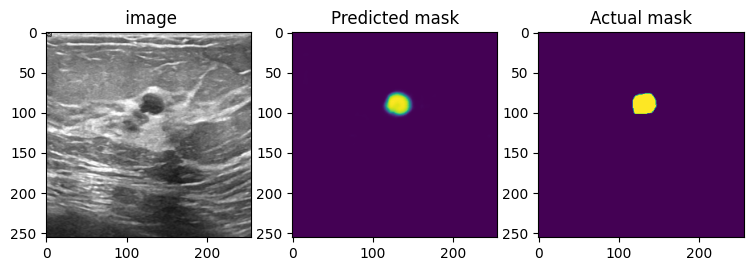

In [ ]:
Prediction_, actuals, masks = predicts(framObjTrain, myTransformer)
Plotter(actuals[1], Prediction_[1][:,:,0], masks[1])

In [ ]:
cimg = 5

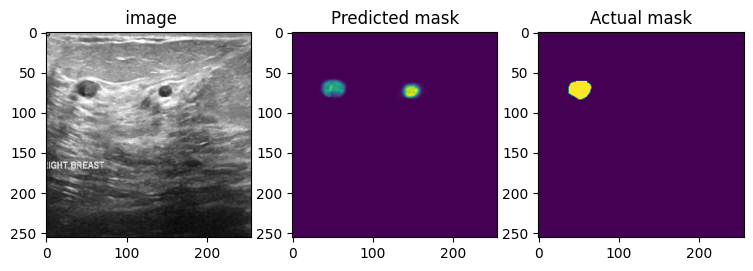

In [ ]:
Plotter(actuals[cimg], Prediction_[cimg][:,:,0], masks[cimg])

**Saving Model**

In [ ]:
#weight file saving
myTransformer.save('BreastCancerSegmentor.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Again




In [ ]:
import os
import cv2
import numpy as np
from PIL import Image  # Import the Image class from the PIL library
from tensorflow.keras.preprocessing.image import load_img, img_to_array

info = [
    'benign'   ,  # 0
    'normal'   ,  # 1
    'malignant',  # 2
]
path = '/content/drive/MyDrive/cancer/Dataset_BUSI_with_GT'
X = []
y = []

label_num = -1

for label_class in os.listdir(path):

    new_path   = os.path.join(path, label_class)
    label_num += 1

    for img in os.listdir(new_path):
        if 'mask' not in img:

            y.append(label_num)
            x = cv2.imread(os.path.join(new_path, img), cv2.IMREAD_GRAYSCALE)
            resized_x = cv2.resize(x, (256, 256))
            processed_x = img_to_array(Image.fromarray(resized_x))
            X.append(processed_x)

# Convert lists to numpy arrays for further processing
X = np.array(X)
y = np.array(y)

# Now you can use X and y for further processing, e.g., training a machine learning model


In [ ]:
X/= 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y = to_categorical(y)

In [ ]:
print(X.shape)
print(y.shape)

(780, 256, 256, 1)
(780, 3)


In [ ]:
print(X.min())
print(X.max())

0.0
1.0


(-0.5, 255.5, 255.5, -0.5)

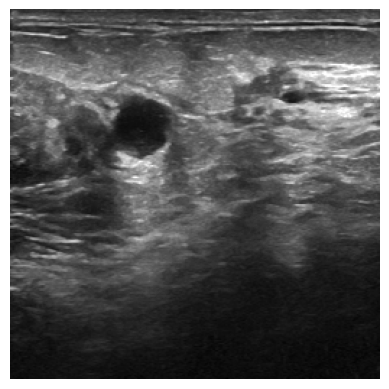

In [ ]:
plt.imshow(X[0], 'gray')
plt.axis('off')

In [ ]:
from keras.models import load_model

In [ ]:
localize = load_model('./BreastCancerSegmentor.h5')

In [ ]:
# Convert grayscale images to RGB format and resize to 256x256
X_rgb = np.repeat(X, 3, axis=-1)
X_resized = np.array([cv2.resize(img, (256, 256)) for img in X_rgb])

# Now predict using the modified data
M = localize.predict(X_resized)


25/25 [==============================] - 3s 99ms/step


4.2801753e-06
1.0


(-0.5, 255.5, 255.5, -0.5)

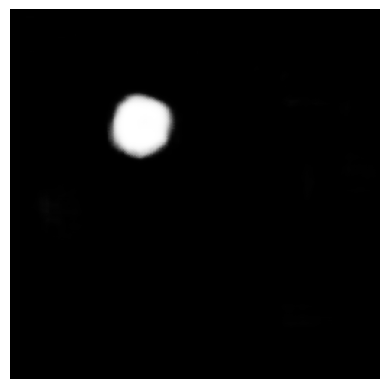

In [ ]:
print(M.min())
print(M.max())

plt.imshow(M[0], 'gray')
plt.axis('off')

In [ ]:
import pandas
import seaborn

Text(0.5, 1.0, 'Distribution of classes accross the entire dataset')

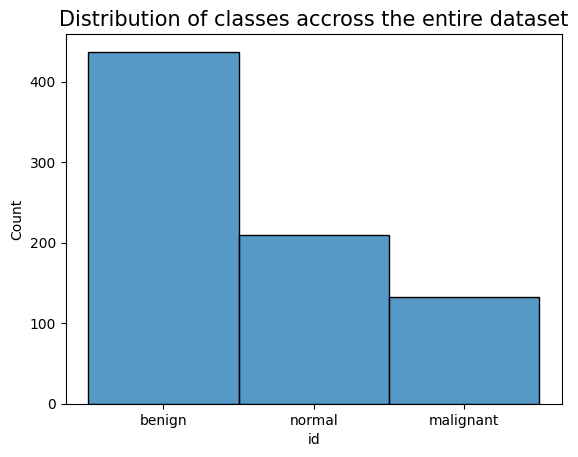

In [ ]:
import pandas
import seaborn
seaborn.histplot(data = pandas.DataFrame({'id' : [info[p] for p in np.argmax(y, axis = 1)]}), x = 'id')
plt.title('Distribution of classes accross the entire dataset', fontsize = 15)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(M, y, test_size = 0.1, shuffle = True, random_state = 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(702, 256, 256, 1)
(702, 3)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(78, 256, 256, 1)
(78, 3)


In [ ]:
from numpy.random import randint

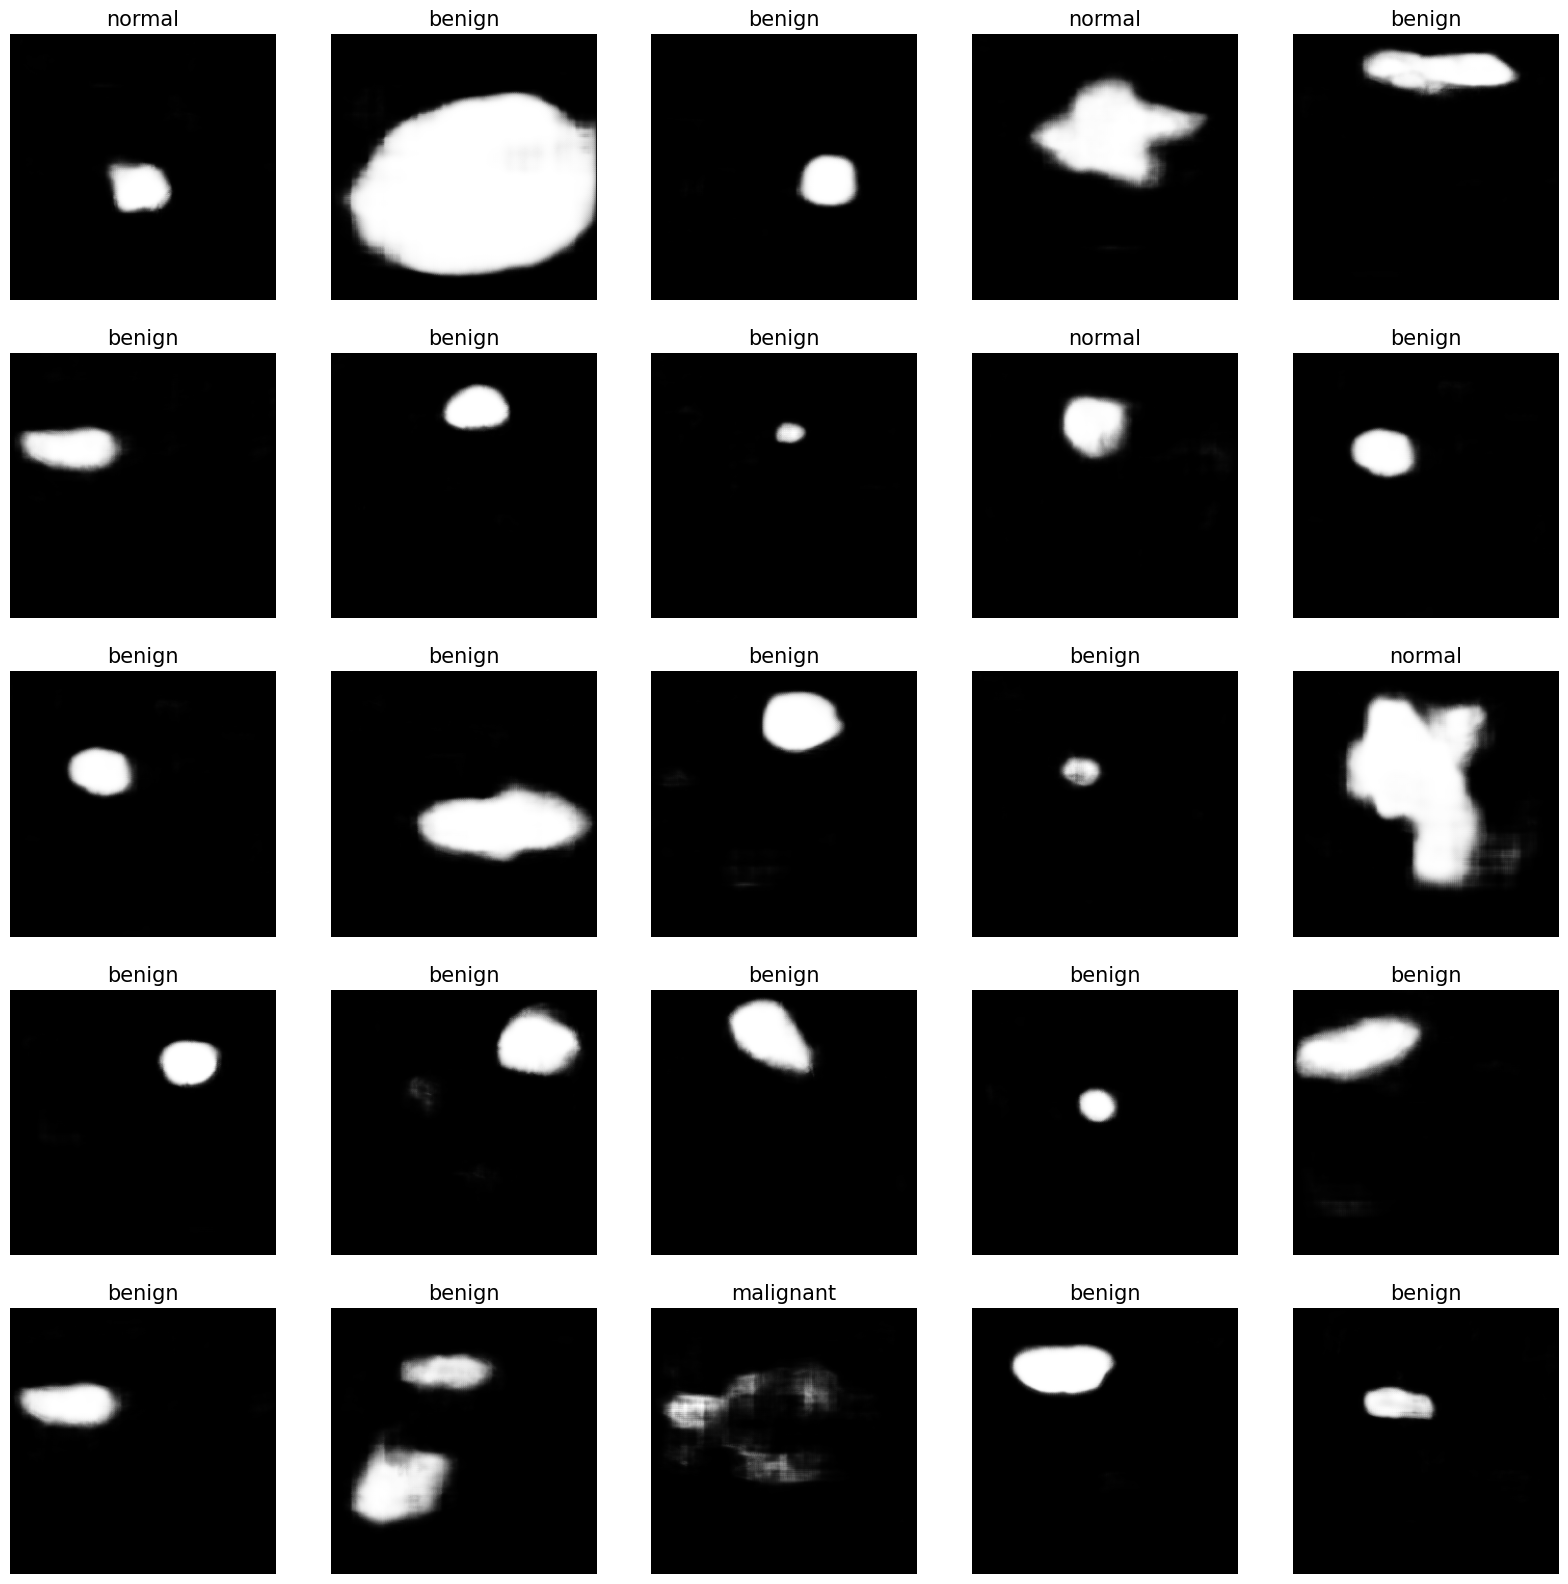

In [ ]:
plt.figure(figsize = (20,20))
i = 0
SIZE = 702
while i < 25 :

    x = randint(0, SIZE)
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[x], 'gray')
    plt.title(f'{info[np.argmax(y_train[x])]}', fontsize = 15)
    plt.axis('off')

    i += 1
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_gen = ImageDataGenerator(horizontal_flip = True, rotation_range = 15, width_shift_range = [-10, 10], height_shift_range = [-10, 10], zoom_range = [0.80, 1.00])

In [ ]:
train_gen.fit(X_train)

In [ ]:
pointer = train_gen.flow(X_train, y_train)

In [ ]:
trainX, trainy = pointer.next()

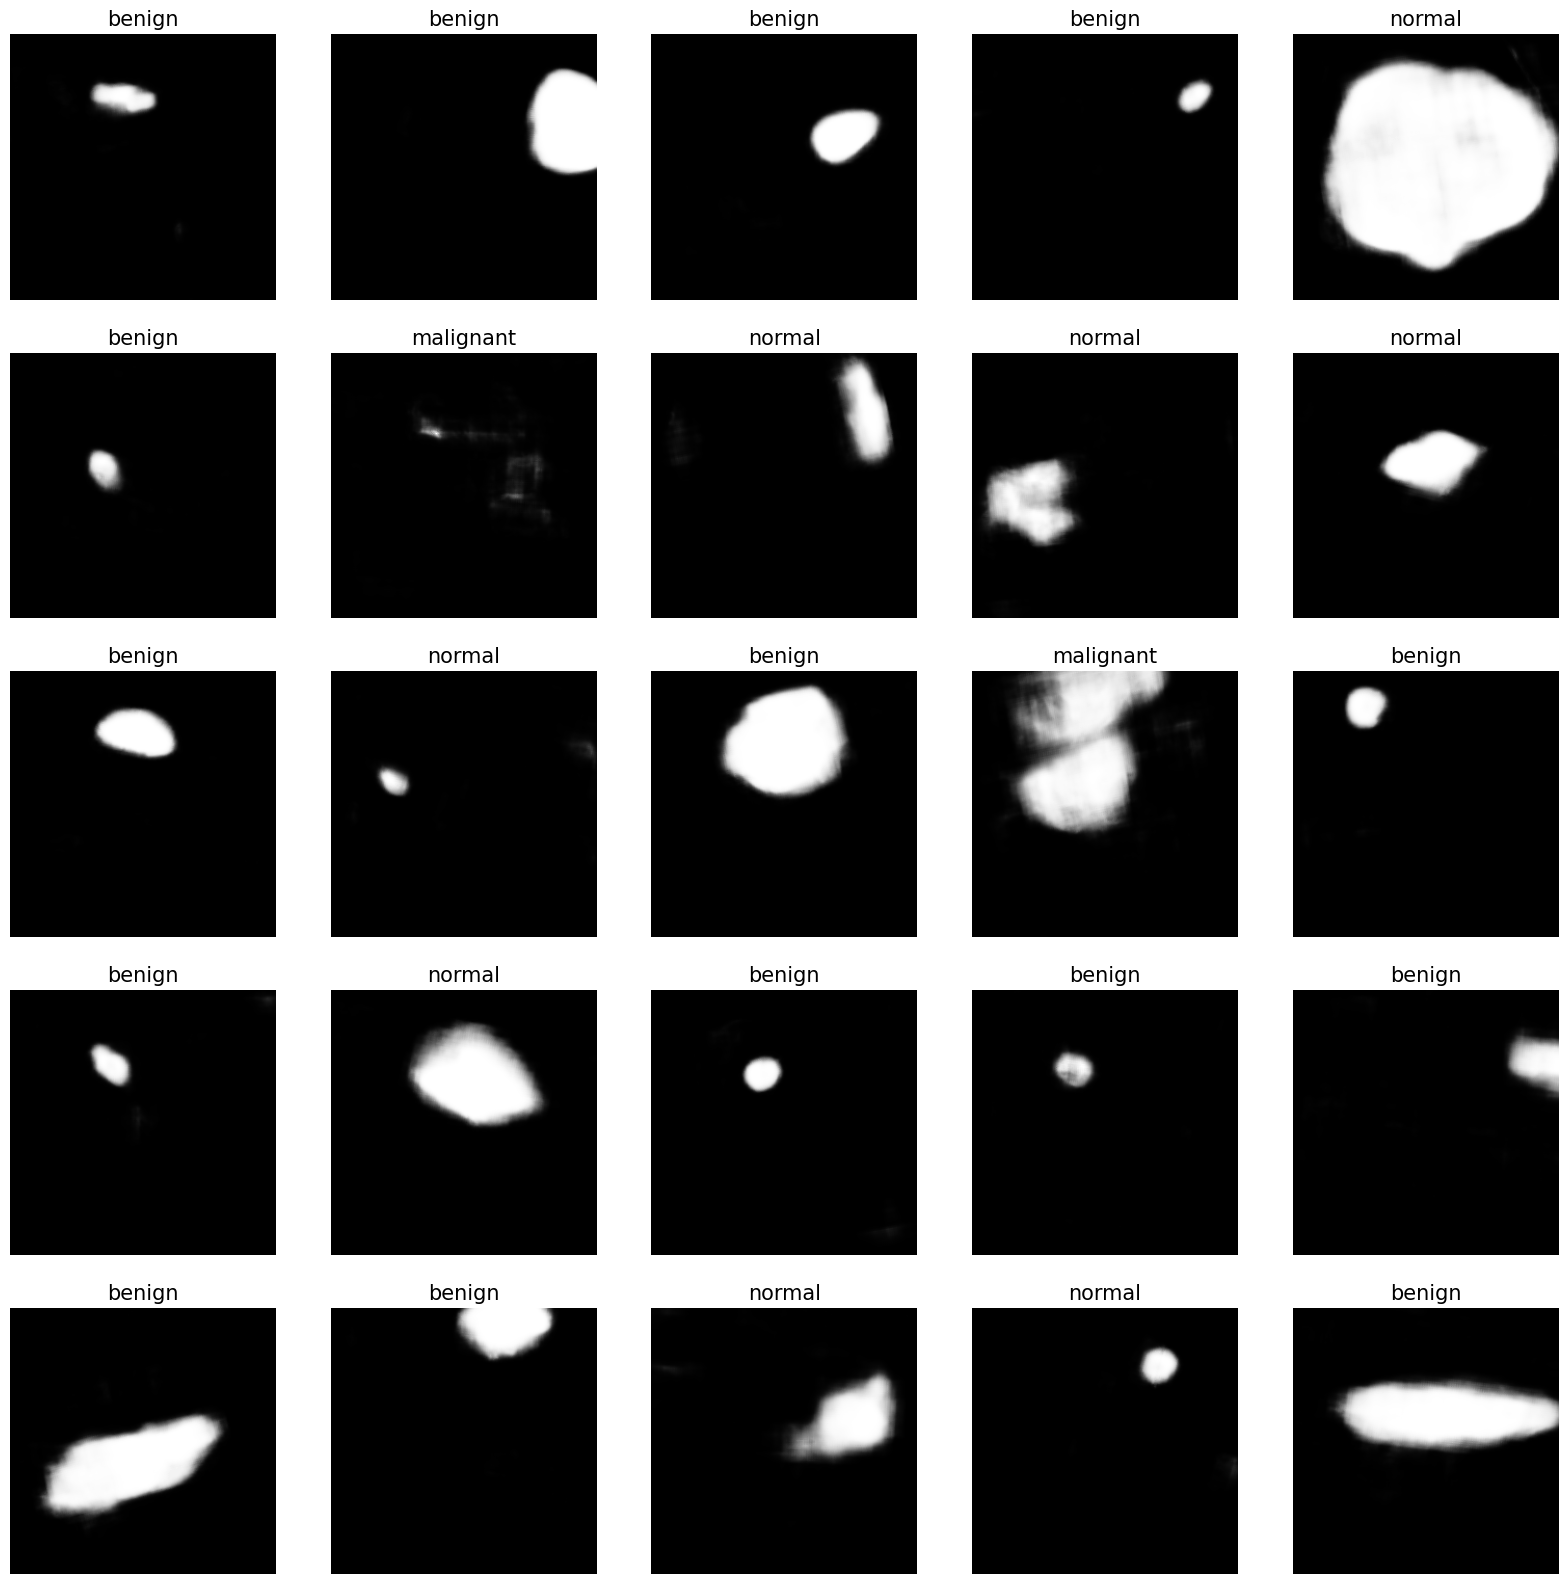

In [ ]:
plt.figure(figsize = (20,20))

i = 0

while i < 25 :

    plt.subplot(5, 5, i+1)
    plt.imshow(trainX[i], 'gray')
    plt.title(f'{info[np.argmax(trainy[i])]}', fontsize = 15)
    plt.axis('off')

    i += 1
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
#changing the datatype
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [ ]:
model = Sequential([
    Rescaling(1./255, input_shape=(256, 256, 1)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for integer-encoded labels
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model

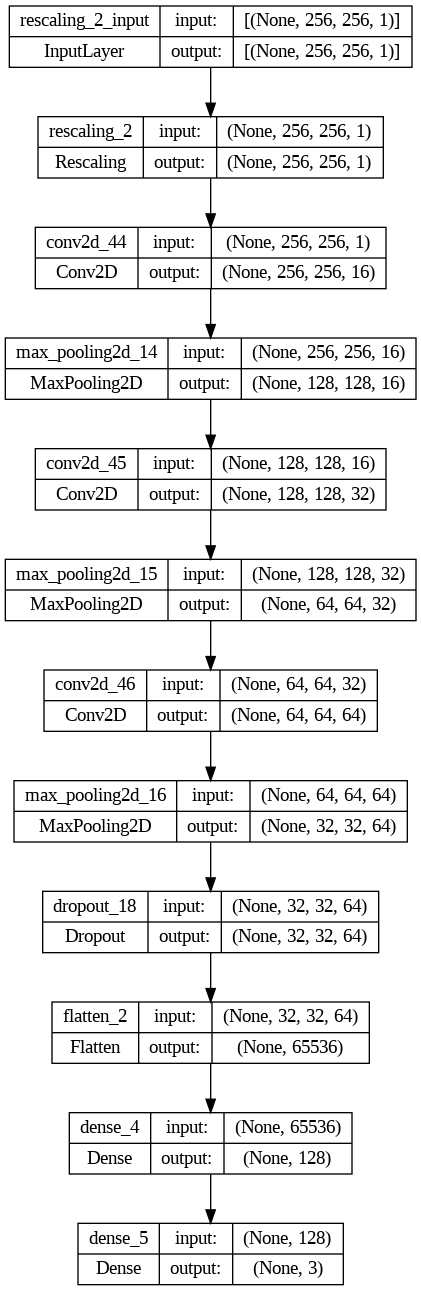

In [ ]:
plot_model(model, 'cancer_classify.png', show_shapes = True)


In [ ]:
# Print the shapes of X_train and X_test to verify their dimensions
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Add this line to print a summary of your model's architecture
model.summary()


X_train shape: (702, 256, 256, 1)
X_test shape: (78, 256, 256, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 128, 128, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                      

In [ ]:
checkp = ModelCheckpoint('./valid_classifier.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
import numpy as np

# Check data types
print("Data types - y_train:", y_train.dtype, "y_test:", y_test.dtype)

# Check unique class indices
unique_train_classes = np.unique(y_train)
unique_test_classes = np.unique(y_test)
print("Unique class indices - Train:", unique_train_classes, "Test:", unique_test_classes)


Data types - y_train: int32 y_test: int32
Unique class indices - Train: [0 1] Test: [0 1]


In [ ]:
# Assuming X_train and y_train are properly prepared
batch_size = 64  # Adjust batch size as needed

# Make sure your data and labels align properly
print(X_train.shape)  # Should be (num_samples, height, width, channels)
print(y_train.shape)  # Should be (num_samples,) for integer-encoded labels
# Training
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=2000, validation_data=(X_test, y_test), callbacks=[checkp])


(702, 256, 256, 1)
(702, 3)
Epoch 1/2000
11/11 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.5413
Epoch 1: val_accuracy improved from -inf to 0.53846, saving model to ./valid_classifier.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
Epoch 751/2000
11/11 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 751: val_accuracy did not improve from 0.78205
11/11 [==============================] - 1s 104ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 3.2715 - val_accuracy: 0.7564
Epoch 752/2000
11/11 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 752: val_accuracy did not improve from 0.78205
11/11 [==============================] - 1s 98ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.3265 - val_accuracy: 0.7436
Epoch 753/2000
11/11 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9986
Epoch 753: val_accuracy did not improve from 0.78205
11/11 [==============================] - 1s 96ms/step - loss: 0.0037 - accuracy: 0.9986 - val_loss: 3.2833 - val_accuracy: 0.7564
Epoch 754/2000
11/11 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9986
Epoch 7

Text(0.5, 1.0, 'Loss val wrt. Epochs')

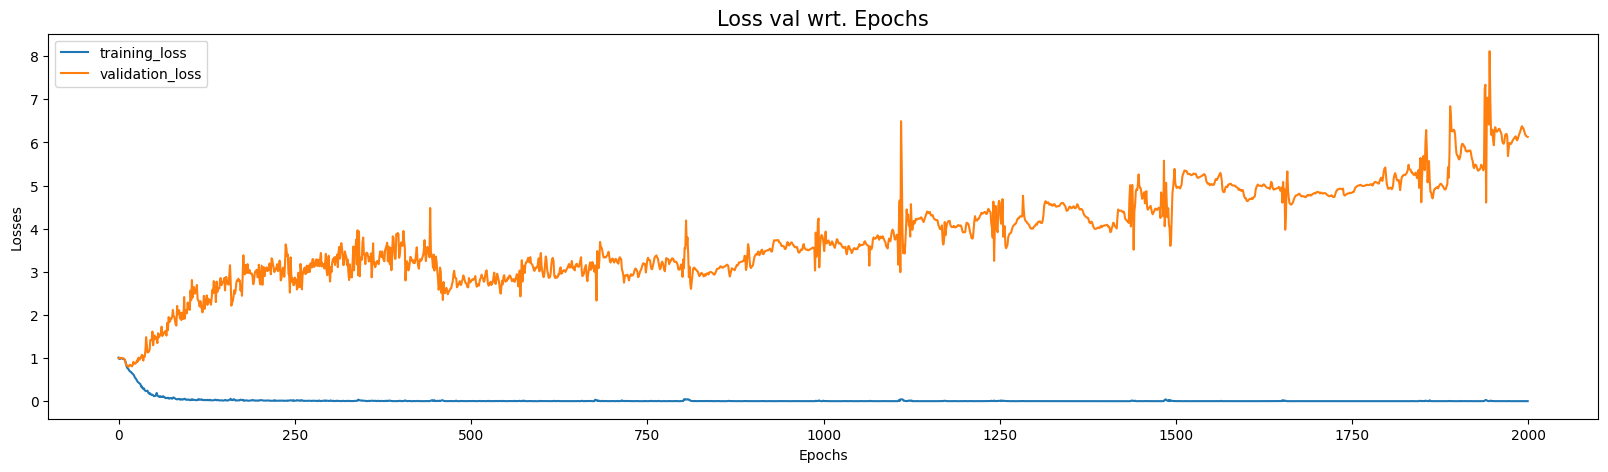

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss val wrt. Epochs', fontsize = 15)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
model = keras.models.load_model('/content/valid_classifier.h5')

In [ ]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 9ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [ ]:
print('Accuracy : ' + str(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names = info))

Accuracy : 0.782051282051282
              precision    recall  f1-score   support

      benign       0.82      0.76      0.79        42
      normal       0.63      0.74      0.68        23
   malignant       1.00      0.92      0.96        13

    accuracy                           0.78        78
   macro avg       0.82      0.81      0.81        78
weighted avg       0.79      0.78      0.79        78



In [ ]:
cm = confusion_matrix(y_test,y_pred)

Text(0.5, 192.72222222222217, 'Predicted')

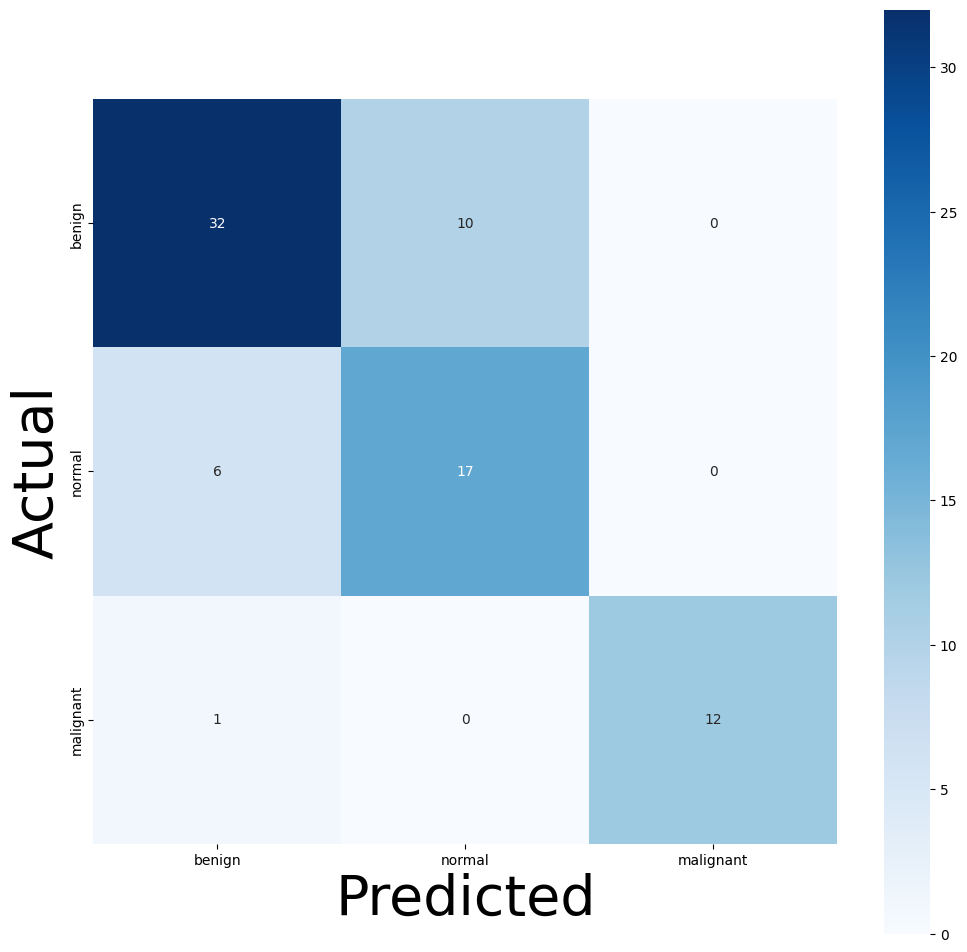

In [ ]:
plt.figure(figsize = (12,12))
ax = seaborn.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)